# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.909602775643842 -2.8196264528156156
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [28]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossQ #+ d_lossR

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [29]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [30]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [31]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(10, 4) actions:(10,)
action size:1


In [32]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [33]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [34]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [35]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
#         # Break episode/epoch loop
#         if np.mean(episodes_total_reward) >= 500:
#             break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/modelQ.ckpt')

Episode:0 meanR:10.0000 gloss:0.0025 dloss:0.6931 dlossR:0.6950 dlossQ:0.6931
Episode:1 meanR:9.5000 gloss:-0.0167 dloss:0.6930 dlossR:0.6821 dlossQ:0.6930
Episode:2 meanR:9.3333 gloss:-0.0730 dloss:0.6914 dlossR:0.6470 dlossQ:0.6914
Episode:3 meanR:13.7500 gloss:0.0335 dloss:0.6928 dlossR:0.7145 dlossQ:0.6928
Episode:4 meanR:14.6000 gloss:0.0478 dloss:0.6928 dlossR:0.7232 dlossQ:0.6928
Episode:5 meanR:14.6667 gloss:0.0731 dloss:0.6917 dlossR:0.7401 dlossQ:0.6917
Episode:6 meanR:14.4286 gloss:0.1232 dloss:0.6885 dlossR:0.7745 dlossQ:0.6885
Episode:7 meanR:13.7500 gloss:0.1645 dloss:0.6830 dlossR:0.8087 dlossQ:0.6830
Episode:8 meanR:13.3333 gloss:0.2101 dloss:0.6752 dlossR:0.8575 dlossQ:0.6752
Episode:9 meanR:12.8000 gloss:0.1852 dloss:0.6780 dlossR:0.8434 dlossQ:0.6780
Episode:10 meanR:12.4545 gloss:0.2076 dloss:0.6709 dlossR:0.8782 dlossQ:0.6709
Episode:11 meanR:12.2500 gloss:0.2558 dloss:0.6530 dlossR:0.9635 dlossQ:0.6530
Episode:12 meanR:12.0000 gloss:0.2473 dloss:0.6521 dlossR:0.96

Episode:110 meanR:9.3600 gloss:0.0049 dloss:0.0000 dlossR:29.1001 dlossQ:0.0000
Episode:111 meanR:9.3600 gloss:0.0033 dloss:0.0000 dlossR:31.7476 dlossQ:0.0000
Episode:112 meanR:9.3700 gloss:0.0035 dloss:0.0000 dlossR:31.7698 dlossQ:0.0000
Episode:113 meanR:9.3700 gloss:0.0038 dloss:0.0000 dlossR:30.0041 dlossQ:0.0000
Episode:114 meanR:9.3700 gloss:0.0033 dloss:0.0000 dlossR:30.1918 dlossQ:0.0000
Episode:115 meanR:9.3700 gloss:0.0036 dloss:0.0000 dlossR:31.5470 dlossQ:0.0000
Episode:116 meanR:9.3500 gloss:0.0039 dloss:0.0000 dlossR:28.2480 dlossQ:0.0000
Episode:117 meanR:9.3500 gloss:0.0031 dloss:0.0000 dlossR:32.0373 dlossQ:0.0000
Episode:118 meanR:9.3300 gloss:0.0035 dloss:0.0000 dlossR:28.6290 dlossQ:0.0000
Episode:119 meanR:9.3400 gloss:0.0033 dloss:0.0000 dlossR:31.6525 dlossQ:0.0000
Episode:120 meanR:9.3400 gloss:0.0036 dloss:0.0000 dlossR:29.9837 dlossQ:0.0000
Episode:121 meanR:9.3500 gloss:0.0039 dloss:0.0000 dlossR:31.2372 dlossQ:0.0000
Episode:122 meanR:9.3700 gloss:0.0029 dl

Episode:220 meanR:9.4000 gloss:0.0010 dloss:0.0000 dlossR:35.2178 dlossQ:0.0000
Episode:221 meanR:9.3900 gloss:0.0010 dloss:0.0000 dlossR:33.4782 dlossQ:0.0000
Episode:222 meanR:9.3900 gloss:0.0008 dloss:0.0000 dlossR:35.5349 dlossQ:0.0000
Episode:223 meanR:9.3800 gloss:0.0009 dloss:0.0000 dlossR:34.1548 dlossQ:0.0000
Episode:224 meanR:9.3800 gloss:0.0008 dloss:0.0000 dlossR:35.8268 dlossQ:0.0000
Episode:225 meanR:9.3700 gloss:0.0007 dloss:0.0000 dlossR:32.5239 dlossQ:0.0000
Episode:226 meanR:9.3600 gloss:0.0011 dloss:0.0000 dlossR:33.6101 dlossQ:0.0000
Episode:227 meanR:9.3600 gloss:0.0006 dloss:0.0000 dlossR:34.6568 dlossQ:0.0000
Episode:228 meanR:9.3700 gloss:0.0008 dloss:0.0000 dlossR:34.4027 dlossQ:0.0000
Episode:229 meanR:9.4000 gloss:0.0008 dloss:0.0000 dlossR:37.4557 dlossQ:0.0000
Episode:230 meanR:9.4000 gloss:0.0007 dloss:0.0000 dlossR:36.1740 dlossQ:0.0000
Episode:231 meanR:9.4000 gloss:0.0008 dloss:0.0000 dlossR:35.6096 dlossQ:0.0000
Episode:232 meanR:9.4200 gloss:0.0010 dl

Episode:328 meanR:9.4000 gloss:0.0003 dloss:0.0000 dlossR:36.7071 dlossQ:0.0000
Episode:329 meanR:9.3700 gloss:0.0005 dloss:0.0000 dlossR:33.9165 dlossQ:0.0000
Episode:330 meanR:9.3800 gloss:0.0004 dloss:0.0000 dlossR:39.5063 dlossQ:0.0000
Episode:331 meanR:9.3900 gloss:0.0004 dloss:0.0000 dlossR:39.5068 dlossQ:0.0000
Episode:332 meanR:9.3800 gloss:0.0005 dloss:0.0000 dlossR:37.0819 dlossQ:0.0000
Episode:333 meanR:9.3800 gloss:0.0004 dloss:0.0000 dlossR:35.8401 dlossQ:0.0000
Episode:334 meanR:9.3600 gloss:0.0003 dloss:0.0000 dlossR:36.4093 dlossQ:0.0000
Episode:335 meanR:9.3600 gloss:0.0004 dloss:0.0000 dlossR:37.9257 dlossQ:0.0000
Episode:336 meanR:9.3500 gloss:0.0003 dloss:0.0000 dlossR:36.3696 dlossQ:0.0000
Episode:337 meanR:9.3500 gloss:0.0003 dloss:0.0000 dlossR:36.4169 dlossQ:0.0000
Episode:338 meanR:9.3600 gloss:0.0004 dloss:0.0000 dlossR:37.7827 dlossQ:0.0000
Episode:339 meanR:9.3600 gloss:0.0003 dloss:0.0000 dlossR:36.7233 dlossQ:0.0000
Episode:340 meanR:9.3500 gloss:0.0004 dl

Episode:442 meanR:9.3800 gloss:0.0002 dloss:0.0000 dlossR:39.4092 dlossQ:0.0000
Episode:443 meanR:9.3900 gloss:0.0002 dloss:0.0000 dlossR:40.1071 dlossQ:0.0000
Episode:444 meanR:9.3900 gloss:0.0002 dloss:0.0000 dlossR:38.9710 dlossQ:0.0000
Episode:445 meanR:9.3900 gloss:0.0002 dloss:0.0000 dlossR:39.8555 dlossQ:0.0000
Episode:446 meanR:9.3800 gloss:0.0002 dloss:0.0000 dlossR:35.4564 dlossQ:0.0000
Episode:447 meanR:9.3800 gloss:0.0002 dloss:0.0000 dlossR:37.4237 dlossQ:0.0000
Episode:448 meanR:9.4000 gloss:0.0002 dloss:0.0000 dlossR:39.3740 dlossQ:0.0000
Episode:449 meanR:9.4100 gloss:0.0002 dloss:0.0000 dlossR:37.8052 dlossQ:0.0000
Episode:450 meanR:9.4000 gloss:0.0002 dloss:0.0000 dlossR:38.2563 dlossQ:0.0000
Episode:451 meanR:9.4000 gloss:0.0002 dloss:0.0000 dlossR:39.2344 dlossQ:0.0000
Episode:452 meanR:9.4100 gloss:0.0003 dloss:0.0000 dlossR:39.0525 dlossQ:0.0000
Episode:453 meanR:9.4300 gloss:0.0003 dloss:0.0000 dlossR:38.6339 dlossQ:0.0000
Episode:454 meanR:9.4200 gloss:0.0002 dl

Episode:547 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:36.9372 dlossQ:0.0000
Episode:548 meanR:9.2600 gloss:0.0002 dloss:0.0000 dlossR:38.3558 dlossQ:0.0000
Episode:549 meanR:9.2700 gloss:0.0002 dloss:0.0000 dlossR:40.3629 dlossQ:0.0000
Episode:550 meanR:9.2600 gloss:0.0001 dloss:0.0000 dlossR:37.2961 dlossQ:0.0000
Episode:551 meanR:9.2500 gloss:0.0001 dloss:0.0000 dlossR:39.1389 dlossQ:0.0000
Episode:552 meanR:9.2300 gloss:0.0001 dloss:0.0000 dlossR:37.1739 dlossQ:0.0000
Episode:553 meanR:9.2200 gloss:0.0001 dloss:0.0000 dlossR:38.9659 dlossQ:0.0000
Episode:554 meanR:9.2300 gloss:0.0002 dloss:0.0000 dlossR:40.2083 dlossQ:0.0000
Episode:555 meanR:9.2400 gloss:0.0001 dloss:0.0000 dlossR:41.0111 dlossQ:0.0000
Episode:556 meanR:9.2300 gloss:0.0001 dloss:0.0000 dlossR:36.9074 dlossQ:0.0000
Episode:557 meanR:9.2100 gloss:0.0001 dloss:0.0000 dlossR:36.8981 dlossQ:0.0000
Episode:558 meanR:9.2100 gloss:0.0001 dloss:0.0000 dlossR:38.7853 dlossQ:0.0000
Episode:559 meanR:9.2200 gloss:0.0001 dl

Episode:656 meanR:9.2500 gloss:0.0001 dloss:0.0000 dlossR:40.7039 dlossQ:0.0000
Episode:657 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:41.3506 dlossQ:0.0000
Episode:658 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:39.5886 dlossQ:0.0000
Episode:659 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:40.0707 dlossQ:0.0000
Episode:660 meanR:9.2500 gloss:0.0001 dloss:0.0000 dlossR:40.3432 dlossQ:0.0000
Episode:661 meanR:9.2400 gloss:0.0001 dloss:0.0000 dlossR:40.3327 dlossQ:0.0000
Episode:662 meanR:9.2500 gloss:0.0001 dloss:0.0000 dlossR:40.1056 dlossQ:0.0000
Episode:663 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:41.5480 dlossQ:0.0000
Episode:664 meanR:9.2600 gloss:0.0001 dloss:0.0000 dlossR:40.0791 dlossQ:0.0000
Episode:665 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:41.6978 dlossQ:0.0000
Episode:666 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:39.7762 dlossQ:0.0000
Episode:667 meanR:9.2700 gloss:0.0001 dloss:0.0000 dlossR:39.5031 dlossQ:0.0000
Episode:668 meanR:9.2800 gloss:0.0001 dl

Episode:766 meanR:9.4400 gloss:0.0001 dloss:0.0000 dlossR:38.1962 dlossQ:0.0000
Episode:767 meanR:9.4400 gloss:0.0001 dloss:0.0000 dlossR:40.4848 dlossQ:0.0000
Episode:768 meanR:9.4400 gloss:0.0001 dloss:0.0000 dlossR:42.0220 dlossQ:0.0000
Episode:769 meanR:9.4300 gloss:0.0001 dloss:0.0000 dlossR:40.4819 dlossQ:0.0000
Episode:770 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:41.4008 dlossQ:0.0000
Episode:771 meanR:9.4100 gloss:0.0001 dloss:0.0000 dlossR:39.8608 dlossQ:0.0000
Episode:772 meanR:9.4100 gloss:0.0001 dloss:0.0000 dlossR:42.1387 dlossQ:0.0000
Episode:773 meanR:9.4100 gloss:0.0001 dloss:0.0000 dlossR:41.7312 dlossQ:0.0000
Episode:774 meanR:9.4100 gloss:0.0001 dloss:0.0000 dlossR:41.0112 dlossQ:0.0000
Episode:775 meanR:9.4100 gloss:0.0001 dloss:0.0000 dlossR:40.3704 dlossQ:0.0000
Episode:776 meanR:9.4300 gloss:0.0001 dloss:0.0000 dlossR:41.8751 dlossQ:0.0000
Episode:777 meanR:9.4300 gloss:0.0001 dloss:0.0000 dlossR:40.6965 dlossQ:0.0000
Episode:778 meanR:9.4200 gloss:0.0001 dl

Episode:874 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:43.2624 dlossQ:0.0000
Episode:875 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:41.3771 dlossQ:0.0000
Episode:876 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:41.7647 dlossQ:0.0000
Episode:877 meanR:9.2800 gloss:0.0001 dloss:0.0000 dlossR:42.4955 dlossQ:0.0000
Episode:878 meanR:9.2900 gloss:0.0001 dloss:0.0000 dlossR:42.3739 dlossQ:0.0000
Episode:879 meanR:9.2900 gloss:0.0001 dloss:0.0000 dlossR:40.8753 dlossQ:0.0000
Episode:880 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:43.2016 dlossQ:0.0000
Episode:881 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:41.4786 dlossQ:0.0000
Episode:882 meanR:9.2800 gloss:0.0001 dloss:0.0000 dlossR:40.9888 dlossQ:0.0000
Episode:883 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:41.9692 dlossQ:0.0000
Episode:884 meanR:9.2800 gloss:0.0001 dloss:0.0000 dlossR:39.1030 dlossQ:0.0000
Episode:885 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:42.9536 dlossQ:0.0000
Episode:886 meanR:9.2700 gloss:0.0000 dl

Episode:984 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:43.3045 dlossQ:0.0000
Episode:985 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:41.0782 dlossQ:0.0000
Episode:986 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:41.6311 dlossQ:0.0000
Episode:987 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:42.3062 dlossQ:0.0000
Episode:988 meanR:9.3800 gloss:0.0001 dloss:0.0000 dlossR:42.6895 dlossQ:0.0000
Episode:989 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:43.6757 dlossQ:0.0000
Episode:990 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:43.2910 dlossQ:0.0000
Episode:991 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:43.5052 dlossQ:0.0000
Episode:992 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:43.0281 dlossQ:0.0000
Episode:993 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:41.4836 dlossQ:0.0000
Episode:994 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:41.5800 dlossQ:0.0000
Episode:995 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:43.1369 dlossQ:0.0000
Episode:996 meanR:9.3800 gloss:0.0000 dl

Episode:1094 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:42.2916 dlossQ:0.0000
Episode:1095 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:44.7814 dlossQ:0.0000
Episode:1096 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:42.1458 dlossQ:0.0000
Episode:1097 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:42.2234 dlossQ:0.0000
Episode:1098 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:43.7436 dlossQ:0.0000
Episode:1099 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:44.0898 dlossQ:0.0000
Episode:1100 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:43.5729 dlossQ:0.0000
Episode:1101 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:42.3564 dlossQ:0.0000
Episode:1102 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:41.9144 dlossQ:0.0000
Episode:1103 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:42.0324 dlossQ:0.0000
Episode:1104 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:44.7949 dlossQ:0.0000
Episode:1105 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:43.1594 dlossQ:0.0000
Episode:1106 meanR:9.3200 gl

Episode:1209 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:44.0080 dlossQ:0.0000
Episode:1210 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:43.1762 dlossQ:0.0000
Episode:1211 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:43.0929 dlossQ:0.0000
Episode:1212 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:45.1695 dlossQ:0.0000
Episode:1213 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:45.2657 dlossQ:0.0000
Episode:1214 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:43.4229 dlossQ:0.0000
Episode:1215 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:44.4087 dlossQ:0.0000
Episode:1216 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:44.2420 dlossQ:0.0000
Episode:1217 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:41.0314 dlossQ:0.0000
Episode:1218 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:44.5057 dlossQ:0.0000
Episode:1219 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:40.2500 dlossQ:0.0000
Episode:1220 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:43.2878 dlossQ:0.0000
Episode:1221 meanR:9.3900 gl

Episode:1327 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:40.5881 dlossQ:0.0000
Episode:1328 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:43.7709 dlossQ:0.0000
Episode:1329 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:43.1033 dlossQ:0.0000
Episode:1330 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:44.8692 dlossQ:0.0000
Episode:1331 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:46.6022 dlossQ:0.0000
Episode:1332 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:44.2216 dlossQ:0.0000
Episode:1333 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:42.8095 dlossQ:0.0000
Episode:1334 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:44.6805 dlossQ:0.0000
Episode:1335 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:44.1692 dlossQ:0.0000
Episode:1336 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:43.5969 dlossQ:0.0000
Episode:1337 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:46.2652 dlossQ:0.0000
Episode:1338 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:44.6045 dlossQ:0.0000
Episode:1339 meanR:9.3800 gl

Episode:1439 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:42.9491 dlossQ:0.0000
Episode:1440 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:42.9913 dlossQ:0.0000
Episode:1441 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:45.1209 dlossQ:0.0000
Episode:1442 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:47.1168 dlossQ:0.0000
Episode:1443 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:44.2760 dlossQ:0.0000
Episode:1444 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:45.0626 dlossQ:0.0000
Episode:1445 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:44.0279 dlossQ:0.0000
Episode:1446 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:41.7851 dlossQ:0.0000
Episode:1447 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:43.9253 dlossQ:0.0000
Episode:1448 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:47.2024 dlossQ:0.0000
Episode:1449 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:43.1950 dlossQ:0.0000
Episode:1450 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:45.8426 dlossQ:0.0000
Episode:1451 meanR:9.3500 gl

Episode:1549 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:43.7363 dlossQ:0.0000
Episode:1550 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:45.7231 dlossQ:0.0000
Episode:1551 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:45.0736 dlossQ:0.0000
Episode:1552 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:44.6870 dlossQ:0.0000
Episode:1553 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:44.1834 dlossQ:0.0000
Episode:1554 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:45.8702 dlossQ:0.0000
Episode:1555 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:44.3025 dlossQ:0.0000
Episode:1556 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:45.7842 dlossQ:0.0000
Episode:1557 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:45.3980 dlossQ:0.0000
Episode:1558 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:45.5726 dlossQ:0.0000
Episode:1559 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:43.6231 dlossQ:0.0000
Episode:1560 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:41.4794 dlossQ:0.0000
Episode:1561 meanR:9.3000 gl

Episode:1667 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:44.7031 dlossQ:0.0000
Episode:1668 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:45.9149 dlossQ:0.0000
Episode:1669 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:43.1334 dlossQ:0.0000
Episode:1670 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:44.7498 dlossQ:0.0000
Episode:1671 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:45.4696 dlossQ:0.0000
Episode:1672 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:45.8824 dlossQ:0.0000
Episode:1673 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:46.0641 dlossQ:0.0000
Episode:1674 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:46.0311 dlossQ:0.0000
Episode:1675 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:46.2601 dlossQ:0.0000
Episode:1676 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:46.2568 dlossQ:0.0000
Episode:1677 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:45.9091 dlossQ:0.0000
Episode:1678 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:42.2668 dlossQ:0.0000
Episode:1679 meanR:9.4300 gl

Episode:1785 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:45.2170 dlossQ:0.0000
Episode:1786 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:42.2620 dlossQ:0.0000
Episode:1787 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:46.2529 dlossQ:0.0000
Episode:1788 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:45.8552 dlossQ:0.0000
Episode:1789 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:47.0681 dlossQ:0.0000
Episode:1790 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:46.6570 dlossQ:0.0000
Episode:1791 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:44.8959 dlossQ:0.0000
Episode:1792 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:48.5117 dlossQ:0.0000
Episode:1793 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:45.7119 dlossQ:0.0000
Episode:1794 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:43.0663 dlossQ:0.0000
Episode:1795 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:46.6198 dlossQ:0.0000
Episode:1796 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:46.2181 dlossQ:0.0000
Episode:1797 meanR:9.3700 gl

Episode:1900 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:45.6611 dlossQ:0.0000
Episode:1901 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:44.3615 dlossQ:0.0000
Episode:1902 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:45.4439 dlossQ:0.0000
Episode:1903 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:42.3145 dlossQ:0.0000
Episode:1904 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:46.0997 dlossQ:0.0000
Episode:1905 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:46.0236 dlossQ:0.0000
Episode:1906 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:45.9304 dlossQ:0.0000
Episode:1907 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:47.1364 dlossQ:0.0000
Episode:1908 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:46.5591 dlossQ:0.0000
Episode:1909 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:43.2924 dlossQ:0.0000
Episode:1910 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:46.5774 dlossQ:0.0000
Episode:1911 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:45.5692 dlossQ:0.0000
Episode:1912 meanR:9.2900 gl

Episode:2016 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:45.3008 dlossQ:0.0000
Episode:2017 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:47.5942 dlossQ:0.0000
Episode:2018 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:46.5083 dlossQ:0.0000
Episode:2019 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:45.4915 dlossQ:0.0000
Episode:2020 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:45.2846 dlossQ:0.0000
Episode:2021 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:45.5119 dlossQ:0.0000
Episode:2022 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:46.8945 dlossQ:0.0000
Episode:2023 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:47.8855 dlossQ:0.0000
Episode:2024 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:45.1820 dlossQ:0.0000
Episode:2025 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:45.7466 dlossQ:0.0000
Episode:2026 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:45.1722 dlossQ:0.0000
Episode:2027 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:45.2510 dlossQ:0.0000
Episode:2028 meanR:9.3300 gl

Episode:2132 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:45.9125 dlossQ:0.0000
Episode:2133 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:47.2158 dlossQ:0.0000
Episode:2134 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:45.7663 dlossQ:0.0000
Episode:2135 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:47.1425 dlossQ:0.0000
Episode:2136 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:47.5966 dlossQ:0.0000
Episode:2137 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:47.2464 dlossQ:0.0000
Episode:2138 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:46.4949 dlossQ:0.0000
Episode:2139 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:47.2465 dlossQ:0.0000
Episode:2140 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:46.8182 dlossQ:0.0000
Episode:2141 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:45.2495 dlossQ:0.0000
Episode:2142 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:47.5707 dlossQ:0.0000
Episode:2143 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:46.9770 dlossQ:0.0000
Episode:2144 meanR:9.4400 gl

Episode:2236 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:44.1343 dlossQ:0.0000
Episode:2237 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:47.3784 dlossQ:0.0000
Episode:2238 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:45.8269 dlossQ:0.0000
Episode:2239 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:47.4797 dlossQ:0.0000
Episode:2240 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:47.4533 dlossQ:0.0000
Episode:2241 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:46.0070 dlossQ:0.0000
Episode:2242 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:45.8507 dlossQ:0.0000
Episode:2243 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:46.8862 dlossQ:0.0000
Episode:2244 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:44.0625 dlossQ:0.0000
Episode:2245 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:43.9633 dlossQ:0.0000
Episode:2246 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:46.6722 dlossQ:0.0000
Episode:2247 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:43.6321 dlossQ:0.0000
Episode:2248 meanR:9.3300 gl

Episode:2348 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:46.3683 dlossQ:0.0000
Episode:2349 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:49.1115 dlossQ:0.0000
Episode:2350 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:46.2376 dlossQ:0.0000
Episode:2351 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:47.5470 dlossQ:0.0000
Episode:2352 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:46.2652 dlossQ:0.0000
Episode:2353 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:45.7351 dlossQ:0.0000
Episode:2354 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:46.9170 dlossQ:0.0000
Episode:2355 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:47.2191 dlossQ:0.0000
Episode:2356 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:47.5592 dlossQ:0.0000
Episode:2357 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:44.9797 dlossQ:0.0000
Episode:2358 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:46.6384 dlossQ:0.0000
Episode:2359 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:49.9157 dlossQ:0.0000
Episode:2360 meanR:9.4600 gl

Episode:2461 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:48.3407 dlossQ:0.0000
Episode:2462 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:46.1497 dlossQ:0.0000
Episode:2463 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:48.5301 dlossQ:0.0000
Episode:2464 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:46.1897 dlossQ:0.0000
Episode:2465 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:48.5441 dlossQ:0.0000
Episode:2466 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:47.7571 dlossQ:0.0000
Episode:2467 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:46.0372 dlossQ:0.0000
Episode:2468 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:47.8427 dlossQ:0.0000
Episode:2469 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:44.7310 dlossQ:0.0000
Episode:2470 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:46.4964 dlossQ:0.0000
Episode:2471 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:46.2232 dlossQ:0.0000
Episode:2472 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:43.9955 dlossQ:0.0000
Episode:2473 meanR:9.3100 gl

Episode:2576 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:48.6134 dlossQ:0.0000
Episode:2577 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:44.4066 dlossQ:0.0000
Episode:2578 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:47.5303 dlossQ:0.0000
Episode:2579 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:46.8118 dlossQ:0.0000
Episode:2580 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:46.5134 dlossQ:0.0000
Episode:2581 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:48.4879 dlossQ:0.0000
Episode:2582 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:47.5244 dlossQ:0.0000
Episode:2583 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:47.3541 dlossQ:0.0000
Episode:2584 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:46.5678 dlossQ:0.0000
Episode:2585 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:46.4851 dlossQ:0.0000
Episode:2586 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:48.1920 dlossQ:0.0000
Episode:2587 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:47.1756 dlossQ:0.0000
Episode:2588 meanR:9.2900 gl

Episode:2681 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:48.3195 dlossQ:0.0000
Episode:2682 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:47.4538 dlossQ:0.0000
Episode:2683 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:48.4822 dlossQ:0.0000
Episode:2684 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:46.3056 dlossQ:0.0000
Episode:2685 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:44.6446 dlossQ:0.0000
Episode:2686 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:50.6547 dlossQ:0.0000
Episode:2687 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:48.1784 dlossQ:0.0000
Episode:2688 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:47.0488 dlossQ:0.0000
Episode:2689 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:46.8161 dlossQ:0.0000
Episode:2690 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:48.5065 dlossQ:0.0000
Episode:2691 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:46.5735 dlossQ:0.0000
Episode:2692 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:46.6659 dlossQ:0.0000
Episode:2693 meanR:9.4200 gl

Episode:2794 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:44.1653 dlossQ:0.0000
Episode:2795 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:48.8344 dlossQ:0.0000
Episode:2796 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:46.7761 dlossQ:0.0000
Episode:2797 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:48.2522 dlossQ:0.0000
Episode:2798 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:46.3691 dlossQ:0.0000
Episode:2799 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:48.1760 dlossQ:0.0000
Episode:2800 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:47.1657 dlossQ:0.0000
Episode:2801 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:46.8216 dlossQ:0.0000
Episode:2802 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:47.8093 dlossQ:0.0000
Episode:2803 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:46.8228 dlossQ:0.0000
Episode:2804 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:48.4199 dlossQ:0.0000
Episode:2805 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:46.7343 dlossQ:0.0000
Episode:2806 meanR:9.3600 gl

Episode:2905 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:49.0247 dlossQ:0.0000
Episode:2906 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:45.3603 dlossQ:0.0000
Episode:2907 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:48.7454 dlossQ:0.0000
Episode:2908 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:48.2188 dlossQ:0.0000
Episode:2909 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:46.4067 dlossQ:0.0000
Episode:2910 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:48.8852 dlossQ:0.0000
Episode:2911 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:45.8730 dlossQ:0.0000
Episode:2912 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:47.5750 dlossQ:0.0000
Episode:2913 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:47.9275 dlossQ:0.0000
Episode:2914 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:49.2328 dlossQ:0.0000
Episode:2915 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:47.3494 dlossQ:0.0000
Episode:2916 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:47.3306 dlossQ:0.0000
Episode:2917 meanR:9.2700 gl

Episode:3022 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:48.5917 dlossQ:0.0000
Episode:3023 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:48.7489 dlossQ:0.0000
Episode:3024 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:47.6846 dlossQ:0.0000
Episode:3025 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:47.6771 dlossQ:0.0000
Episode:3026 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:49.1213 dlossQ:0.0000
Episode:3027 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:47.4955 dlossQ:0.0000
Episode:3028 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:49.7217 dlossQ:0.0000
Episode:3029 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:49.1304 dlossQ:0.0000
Episode:3030 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:46.6489 dlossQ:0.0000
Episode:3031 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:46.9367 dlossQ:0.0000
Episode:3032 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:47.6020 dlossQ:0.0000
Episode:3033 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:50.7261 dlossQ:0.0000
Episode:3034 meanR:9.3800 gl

Episode:3141 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:45.3248 dlossQ:0.0000
Episode:3142 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:48.7285 dlossQ:0.0000
Episode:3143 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:48.1693 dlossQ:0.0000
Episode:3144 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:49.9899 dlossQ:0.0000
Episode:3145 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:49.1020 dlossQ:0.0000
Episode:3146 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:50.0828 dlossQ:0.0000
Episode:3147 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:47.2390 dlossQ:0.0000
Episode:3148 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:48.0035 dlossQ:0.0000
Episode:3149 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:48.1334 dlossQ:0.0000
Episode:3150 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:48.5432 dlossQ:0.0000
Episode:3151 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:48.4720 dlossQ:0.0000
Episode:3152 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:49.9172 dlossQ:0.0000
Episode:3153 meanR:9.2800 gl

Episode:3243 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:46.6175 dlossQ:0.0000
Episode:3244 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:46.3692 dlossQ:0.0000
Episode:3245 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:49.5106 dlossQ:0.0000
Episode:3246 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:49.9296 dlossQ:0.0000
Episode:3247 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:48.4004 dlossQ:0.0000
Episode:3248 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:47.5285 dlossQ:0.0000
Episode:3249 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:49.1757 dlossQ:0.0000
Episode:3250 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:49.8597 dlossQ:0.0000
Episode:3251 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:48.2485 dlossQ:0.0000
Episode:3252 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:48.2354 dlossQ:0.0000
Episode:3253 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:47.9893 dlossQ:0.0000
Episode:3254 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:47.4924 dlossQ:0.0000
Episode:3255 meanR:9.3300 gl

Episode:3362 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:50.2873 dlossQ:0.0000
Episode:3363 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:50.3058 dlossQ:0.0000
Episode:3364 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:50.0130 dlossQ:0.0000
Episode:3365 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:50.2303 dlossQ:0.0000
Episode:3366 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:48.8719 dlossQ:0.0000
Episode:3367 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:48.0538 dlossQ:0.0000
Episode:3368 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:49.9309 dlossQ:0.0000
Episode:3369 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:47.5696 dlossQ:0.0000
Episode:3370 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:47.6873 dlossQ:0.0000
Episode:3371 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:49.7143 dlossQ:0.0000
Episode:3372 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:46.0606 dlossQ:0.0000
Episode:3373 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:46.1624 dlossQ:0.0000
Episode:3374 meanR:9.4700 gl

Episode:3473 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:50.0458 dlossQ:0.0000
Episode:3474 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:50.2641 dlossQ:0.0000
Episode:3475 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:51.6460 dlossQ:0.0000
Episode:3476 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:50.7690 dlossQ:0.0000
Episode:3477 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:50.2492 dlossQ:0.0000
Episode:3478 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:48.2061 dlossQ:0.0000
Episode:3479 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:49.3154 dlossQ:0.0000
Episode:3480 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:49.7957 dlossQ:0.0000
Episode:3481 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:50.2201 dlossQ:0.0000
Episode:3482 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:49.6998 dlossQ:0.0000
Episode:3483 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:50.4525 dlossQ:0.0000
Episode:3484 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:48.5833 dlossQ:0.0000
Episode:3485 meanR:9.4700 gl

Episode:3591 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:47.8192 dlossQ:0.0000
Episode:3592 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:50.0137 dlossQ:0.0000
Episode:3593 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:50.4125 dlossQ:0.0000
Episode:3594 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:48.8959 dlossQ:0.0000
Episode:3595 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:45.7222 dlossQ:0.0000
Episode:3596 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:51.1614 dlossQ:0.0000
Episode:3597 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:48.6506 dlossQ:0.0000
Episode:3598 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:46.8728 dlossQ:0.0000
Episode:3599 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:50.1496 dlossQ:0.0000
Episode:3600 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:46.6087 dlossQ:0.0000
Episode:3601 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:50.6959 dlossQ:0.0000
Episode:3602 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:46.5439 dlossQ:0.0000
Episode:3603 meanR:9.3200 gl

Episode:3708 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:48.4529 dlossQ:0.0000
Episode:3709 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:48.4557 dlossQ:0.0000
Episode:3710 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:49.4240 dlossQ:0.0000
Episode:3711 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:48.1668 dlossQ:0.0000
Episode:3712 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:47.4980 dlossQ:0.0000
Episode:3713 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:48.6341 dlossQ:0.0000
Episode:3714 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:49.2743 dlossQ:0.0000
Episode:3715 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:48.7858 dlossQ:0.0000
Episode:3716 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:48.7120 dlossQ:0.0000
Episode:3717 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:50.2388 dlossQ:0.0000
Episode:3718 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:45.4867 dlossQ:0.0000
Episode:3719 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:49.4029 dlossQ:0.0000
Episode:3720 meanR:9.3000 gl

Episode:3817 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:50.3580 dlossQ:0.0000
Episode:3818 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:48.8714 dlossQ:0.0000
Episode:3819 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:50.0460 dlossQ:0.0000
Episode:3820 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:50.3388 dlossQ:0.0000
Episode:3821 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:50.7012 dlossQ:0.0000
Episode:3822 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:46.6930 dlossQ:0.0000
Episode:3823 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:49.5327 dlossQ:0.0000
Episode:3824 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:49.7371 dlossQ:0.0000
Episode:3825 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:49.1741 dlossQ:0.0000
Episode:3826 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:50.1733 dlossQ:0.0000
Episode:3827 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:48.3421 dlossQ:0.0000
Episode:3828 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:48.9552 dlossQ:0.0000
Episode:3829 meanR:9.4200 gl

Episode:3936 meanR:9.2000 gloss:0.0000 dloss:0.0000 dlossR:51.5598 dlossQ:0.0000
Episode:3937 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:50.2279 dlossQ:0.0000
Episode:3938 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:50.9342 dlossQ:0.0000
Episode:3939 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:49.8389 dlossQ:0.0000
Episode:3940 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.4654 dlossQ:0.0000
Episode:3941 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:48.7654 dlossQ:0.0000
Episode:3942 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:49.7894 dlossQ:0.0000
Episode:3943 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:50.6315 dlossQ:0.0000
Episode:3944 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:49.4835 dlossQ:0.0000
Episode:3945 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.8120 dlossQ:0.0000
Episode:3946 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:49.7091 dlossQ:0.0000
Episode:3947 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:48.8637 dlossQ:0.0000
Episode:3948 meanR:9.2500 gl

Episode:4056 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:48.4096 dlossQ:0.0000
Episode:4057 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:50.4914 dlossQ:0.0000
Episode:4058 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:46.7993 dlossQ:0.0000
Episode:4059 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:49.0891 dlossQ:0.0000
Episode:4060 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:46.8688 dlossQ:0.0000
Episode:4061 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:49.3983 dlossQ:0.0000
Episode:4062 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:50.8454 dlossQ:0.0000
Episode:4063 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:47.7060 dlossQ:0.0000
Episode:4064 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:49.4316 dlossQ:0.0000
Episode:4065 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.3653 dlossQ:0.0000
Episode:4066 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:48.2531 dlossQ:0.0000
Episode:4067 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:46.5883 dlossQ:0.0000
Episode:4068 meanR:9.3600 gl

Episode:4166 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:49.4253 dlossQ:0.0000
Episode:4167 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:49.0316 dlossQ:0.0000
Episode:4168 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.3680 dlossQ:0.0000
Episode:4169 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:48.9649 dlossQ:0.0000
Episode:4170 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:50.7332 dlossQ:0.0000
Episode:4171 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:47.5434 dlossQ:0.0000
Episode:4172 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:49.7134 dlossQ:0.0000
Episode:4173 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:50.0735 dlossQ:0.0000
Episode:4174 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:50.4448 dlossQ:0.0000
Episode:4175 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:51.5321 dlossQ:0.0000
Episode:4176 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:49.1320 dlossQ:0.0000
Episode:4177 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:50.1560 dlossQ:0.0000
Episode:4178 meanR:9.4000 gl

Episode:4285 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:49.9659 dlossQ:0.0000
Episode:4286 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:49.1187 dlossQ:0.0000
Episode:4287 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:51.2784 dlossQ:0.0000
Episode:4288 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:48.8583 dlossQ:0.0000
Episode:4289 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:51.6605 dlossQ:0.0000
Episode:4290 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:51.7928 dlossQ:0.0000
Episode:4291 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:51.8078 dlossQ:0.0000
Episode:4292 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.5873 dlossQ:0.0000
Episode:4293 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.3980 dlossQ:0.0000
Episode:4294 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:50.7402 dlossQ:0.0000
Episode:4295 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:51.5554 dlossQ:0.0000
Episode:4296 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:51.0152 dlossQ:0.0000
Episode:4297 meanR:9.3900 gl

Episode:4388 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:49.0600 dlossQ:0.0000
Episode:4389 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:50.0659 dlossQ:0.0000
Episode:4390 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:51.2839 dlossQ:0.0000
Episode:4391 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:50.3877 dlossQ:0.0000
Episode:4392 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:50.0899 dlossQ:0.0000
Episode:4393 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:47.9248 dlossQ:0.0000
Episode:4394 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:51.7432 dlossQ:0.0000
Episode:4395 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:47.7343 dlossQ:0.0000
Episode:4396 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:51.9842 dlossQ:0.0000
Episode:4397 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:49.8723 dlossQ:0.0000
Episode:4398 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:47.9778 dlossQ:0.0000
Episode:4399 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:49.3819 dlossQ:0.0000
Episode:4400 meanR:9.3800 gl

Episode:4490 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:49.4150 dlossQ:0.0000
Episode:4491 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:50.1531 dlossQ:0.0000
Episode:4492 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:50.9345 dlossQ:0.0000
Episode:4493 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:52.1162 dlossQ:0.0000
Episode:4494 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:49.0468 dlossQ:0.0000
Episode:4495 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:48.7911 dlossQ:0.0000
Episode:4496 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:50.3991 dlossQ:0.0000
Episode:4497 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:50.9843 dlossQ:0.0000
Episode:4498 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.0445 dlossQ:0.0000
Episode:4499 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.6654 dlossQ:0.0000
Episode:4500 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.1111 dlossQ:0.0000
Episode:4501 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:49.0023 dlossQ:0.0000
Episode:4502 meanR:9.2700 gl

Episode:4601 meanR:9.5200 gloss:0.0000 dloss:0.0000 dlossR:54.2027 dlossQ:0.0000
Episode:4602 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:49.7779 dlossQ:0.0000
Episode:4603 meanR:9.5200 gloss:0.0000 dloss:0.0000 dlossR:51.8458 dlossQ:0.0000
Episode:4604 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:49.4908 dlossQ:0.0000
Episode:4605 meanR:9.5200 gloss:0.0000 dloss:0.0000 dlossR:51.6473 dlossQ:0.0000
Episode:4606 meanR:9.5200 gloss:0.0000 dloss:0.0000 dlossR:50.6732 dlossQ:0.0000
Episode:4607 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:50.5500 dlossQ:0.0000
Episode:4608 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:49.9010 dlossQ:0.0000
Episode:4609 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:50.6586 dlossQ:0.0000
Episode:4610 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:50.3639 dlossQ:0.0000
Episode:4611 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:49.2809 dlossQ:0.0000
Episode:4612 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:49.8037 dlossQ:0.0000
Episode:4613 meanR:9.4800 gl

Episode:4716 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:54.5415 dlossQ:0.0000
Episode:4717 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:52.6996 dlossQ:0.0000
Episode:4718 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:51.6425 dlossQ:0.0000
Episode:4719 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:48.1239 dlossQ:0.0000
Episode:4720 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:50.3263 dlossQ:0.0000
Episode:4721 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:51.9868 dlossQ:0.0000
Episode:4722 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:49.7849 dlossQ:0.0000
Episode:4723 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:50.8585 dlossQ:0.0000
Episode:4724 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:51.0956 dlossQ:0.0000
Episode:4725 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:50.0677 dlossQ:0.0000
Episode:4726 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:51.8433 dlossQ:0.0000
Episode:4727 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.8346 dlossQ:0.0000
Episode:4728 meanR:9.3000 gl

Episode:4830 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.7716 dlossQ:0.0000
Episode:4831 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:47.8015 dlossQ:0.0000
Episode:4832 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:49.7539 dlossQ:0.0000
Episode:4833 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.3132 dlossQ:0.0000
Episode:4834 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:48.3336 dlossQ:0.0000
Episode:4835 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:53.3886 dlossQ:0.0000
Episode:4836 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.4905 dlossQ:0.0000
Episode:4837 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:49.9269 dlossQ:0.0000
Episode:4838 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:50.3510 dlossQ:0.0000
Episode:4839 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:49.8192 dlossQ:0.0000
Episode:4840 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.1796 dlossQ:0.0000
Episode:4841 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:50.5511 dlossQ:0.0000
Episode:4842 meanR:9.4100 gl

Episode:4948 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.2031 dlossQ:0.0000
Episode:4949 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:52.0163 dlossQ:0.0000
Episode:4950 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.1590 dlossQ:0.0000
Episode:4951 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:50.4967 dlossQ:0.0000
Episode:4952 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:49.9258 dlossQ:0.0000
Episode:4953 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:50.3751 dlossQ:0.0000
Episode:4954 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:51.4802 dlossQ:0.0000
Episode:4955 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.4743 dlossQ:0.0000
Episode:4956 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.9526 dlossQ:0.0000
Episode:4957 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.8734 dlossQ:0.0000
Episode:4958 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:51.2787 dlossQ:0.0000
Episode:4959 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.5862 dlossQ:0.0000
Episode:4960 meanR:9.2600 gl

Episode:5058 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:51.3399 dlossQ:0.0000
Episode:5059 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:50.9381 dlossQ:0.0000
Episode:5060 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:48.4122 dlossQ:0.0000
Episode:5061 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:50.6655 dlossQ:0.0000
Episode:5062 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:52.6968 dlossQ:0.0000
Episode:5063 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:52.0715 dlossQ:0.0000
Episode:5064 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:50.9576 dlossQ:0.0000
Episode:5065 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:50.9296 dlossQ:0.0000
Episode:5066 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:48.3177 dlossQ:0.0000
Episode:5067 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:52.5366 dlossQ:0.0000
Episode:5068 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:51.0856 dlossQ:0.0000
Episode:5069 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:52.1414 dlossQ:0.0000
Episode:5070 meanR:9.4400 gl

Episode:5174 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.7810 dlossQ:0.0000
Episode:5175 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:50.8901 dlossQ:0.0000
Episode:5176 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:52.3203 dlossQ:0.0000
Episode:5177 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:48.7033 dlossQ:0.0000
Episode:5178 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:50.9842 dlossQ:0.0000
Episode:5179 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.5144 dlossQ:0.0000
Episode:5180 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.3821 dlossQ:0.0000
Episode:5181 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:50.8378 dlossQ:0.0000
Episode:5182 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:52.9766 dlossQ:0.0000
Episode:5183 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:52.4850 dlossQ:0.0000
Episode:5184 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:50.8183 dlossQ:0.0000
Episode:5185 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:50.8454 dlossQ:0.0000
Episode:5186 meanR:9.3000 gl

Episode:5287 meanR:9.5400 gloss:0.0000 dloss:0.0000 dlossR:51.0583 dlossQ:0.0000
Episode:5288 meanR:9.5400 gloss:0.0000 dloss:0.0000 dlossR:50.2706 dlossQ:0.0000
Episode:5289 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:50.2512 dlossQ:0.0000
Episode:5290 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:52.2732 dlossQ:0.0000
Episode:5291 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:52.4089 dlossQ:0.0000
Episode:5292 meanR:9.5500 gloss:0.0000 dloss:0.0000 dlossR:52.9072 dlossQ:0.0000
Episode:5293 meanR:9.5500 gloss:0.0000 dloss:0.0000 dlossR:53.1622 dlossQ:0.0000
Episode:5294 meanR:9.5500 gloss:0.0000 dloss:0.0000 dlossR:52.8596 dlossQ:0.0000
Episode:5295 meanR:9.5600 gloss:0.0000 dloss:0.0000 dlossR:52.7042 dlossQ:0.0000
Episode:5296 meanR:9.5700 gloss:0.0000 dloss:0.0000 dlossR:55.0112 dlossQ:0.0000
Episode:5297 meanR:9.5800 gloss:0.0000 dloss:0.0000 dlossR:52.2069 dlossQ:0.0000
Episode:5298 meanR:9.5700 gloss:0.0000 dloss:0.0000 dlossR:51.3612 dlossQ:0.0000
Episode:5299 meanR:9.5800 gl

Episode:5393 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:49.3196 dlossQ:0.0000
Episode:5394 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.9418 dlossQ:0.0000
Episode:5395 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.0508 dlossQ:0.0000
Episode:5396 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.3749 dlossQ:0.0000
Episode:5397 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.6781 dlossQ:0.0000
Episode:5398 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.0066 dlossQ:0.0000
Episode:5399 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.4484 dlossQ:0.0000
Episode:5400 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.6095 dlossQ:0.0000
Episode:5401 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:51.2487 dlossQ:0.0000
Episode:5402 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.3087 dlossQ:0.0000
Episode:5403 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:52.8143 dlossQ:0.0000
Episode:5404 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:53.0974 dlossQ:0.0000
Episode:5405 meanR:9.4000 gl

Episode:5503 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:50.8908 dlossQ:0.0000
Episode:5504 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:48.4808 dlossQ:0.0000
Episode:5505 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:48.4732 dlossQ:0.0000
Episode:5506 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.9443 dlossQ:0.0000
Episode:5507 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:51.9246 dlossQ:0.0000
Episode:5508 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:51.0460 dlossQ:0.0000
Episode:5509 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:52.9121 dlossQ:0.0000
Episode:5510 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:50.9339 dlossQ:0.0000
Episode:5511 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:50.8329 dlossQ:0.0000
Episode:5512 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:51.3308 dlossQ:0.0000
Episode:5513 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:52.4542 dlossQ:0.0000
Episode:5514 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:49.6899 dlossQ:0.0000
Episode:5515 meanR:9.3100 gl

Episode:5620 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:49.3113 dlossQ:0.0000
Episode:5621 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:53.4749 dlossQ:0.0000
Episode:5622 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:50.9563 dlossQ:0.0000
Episode:5623 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.2692 dlossQ:0.0000
Episode:5624 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:51.6245 dlossQ:0.0000
Episode:5625 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:53.6917 dlossQ:0.0000
Episode:5626 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:53.4623 dlossQ:0.0000
Episode:5627 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:53.8629 dlossQ:0.0000
Episode:5628 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.2970 dlossQ:0.0000
Episode:5629 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.9123 dlossQ:0.0000
Episode:5630 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:49.6025 dlossQ:0.0000
Episode:5631 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.1675 dlossQ:0.0000
Episode:5632 meanR:9.2600 gl

Episode:5730 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:54.7237 dlossQ:0.0000
Episode:5731 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:52.2830 dlossQ:0.0000
Episode:5732 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.0501 dlossQ:0.0000
Episode:5733 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.9974 dlossQ:0.0000
Episode:5734 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:51.2236 dlossQ:0.0000
Episode:5735 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.7031 dlossQ:0.0000
Episode:5736 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.4058 dlossQ:0.0000
Episode:5737 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:48.7650 dlossQ:0.0000
Episode:5738 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.8552 dlossQ:0.0000
Episode:5739 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.9076 dlossQ:0.0000
Episode:5740 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.4835 dlossQ:0.0000
Episode:5741 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:51.1906 dlossQ:0.0000
Episode:5742 meanR:9.2500 gl

Episode:5839 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:52.0481 dlossQ:0.0000
Episode:5840 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:53.2239 dlossQ:0.0000
Episode:5841 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:53.5126 dlossQ:0.0000
Episode:5842 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:53.0388 dlossQ:0.0000
Episode:5843 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:53.7312 dlossQ:0.0000
Episode:5844 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:52.0659 dlossQ:0.0000
Episode:5845 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:51.7222 dlossQ:0.0000
Episode:5846 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.1789 dlossQ:0.0000
Episode:5847 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:54.1089 dlossQ:0.0000
Episode:5848 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:52.2561 dlossQ:0.0000
Episode:5849 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.0479 dlossQ:0.0000
Episode:5850 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.4062 dlossQ:0.0000
Episode:5851 meanR:9.4100 gl

Episode:5942 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:51.9120 dlossQ:0.0000
Episode:5943 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:51.2948 dlossQ:0.0000
Episode:5944 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:54.0481 dlossQ:0.0000
Episode:5945 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.1038 dlossQ:0.0000
Episode:5946 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:51.4780 dlossQ:0.0000
Episode:5947 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.4239 dlossQ:0.0000
Episode:5948 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.1244 dlossQ:0.0000
Episode:5949 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:52.1363 dlossQ:0.0000
Episode:5950 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.0456 dlossQ:0.0000
Episode:5951 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:52.4559 dlossQ:0.0000
Episode:5952 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:54.7425 dlossQ:0.0000
Episode:5953 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:52.0817 dlossQ:0.0000
Episode:5954 meanR:9.2600 gl

Episode:6061 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:49.6927 dlossQ:0.0000
Episode:6062 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.5306 dlossQ:0.0000
Episode:6063 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.6291 dlossQ:0.0000
Episode:6064 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:49.6153 dlossQ:0.0000
Episode:6065 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.3650 dlossQ:0.0000
Episode:6066 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.1713 dlossQ:0.0000
Episode:6067 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.0497 dlossQ:0.0000
Episode:6068 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:52.4341 dlossQ:0.0000
Episode:6069 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:51.0159 dlossQ:0.0000
Episode:6070 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.4538 dlossQ:0.0000
Episode:6071 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:51.8183 dlossQ:0.0000
Episode:6072 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:50.2644 dlossQ:0.0000
Episode:6073 meanR:9.2700 gl

Episode:6178 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.0369 dlossQ:0.0000
Episode:6179 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:51.7540 dlossQ:0.0000
Episode:6180 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:53.6086 dlossQ:0.0000
Episode:6181 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:49.3256 dlossQ:0.0000
Episode:6182 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:55.4130 dlossQ:0.0000
Episode:6183 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:53.5954 dlossQ:0.0000
Episode:6184 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.8851 dlossQ:0.0000
Episode:6185 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:54.9753 dlossQ:0.0000
Episode:6186 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:49.6380 dlossQ:0.0000
Episode:6187 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:54.0201 dlossQ:0.0000
Episode:6188 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:53.6734 dlossQ:0.0000
Episode:6189 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:54.2021 dlossQ:0.0000
Episode:6190 meanR:9.4600 gl

Episode:6281 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:54.1192 dlossQ:0.0000
Episode:6282 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:51.9380 dlossQ:0.0000
Episode:6283 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:52.9153 dlossQ:0.0000
Episode:6284 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:50.0212 dlossQ:0.0000
Episode:6285 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.5106 dlossQ:0.0000
Episode:6286 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:52.5766 dlossQ:0.0000
Episode:6287 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:52.5031 dlossQ:0.0000
Episode:6288 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.7354 dlossQ:0.0000
Episode:6289 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.7185 dlossQ:0.0000
Episode:6290 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:51.8070 dlossQ:0.0000
Episode:6291 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:53.5563 dlossQ:0.0000
Episode:6292 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.9321 dlossQ:0.0000
Episode:6293 meanR:9.3800 gl

Episode:6399 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:56.4126 dlossQ:0.0000
Episode:6400 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.1143 dlossQ:0.0000
Episode:6401 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:56.0494 dlossQ:0.0000
Episode:6402 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.4466 dlossQ:0.0000
Episode:6403 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:52.9435 dlossQ:0.0000
Episode:6404 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:55.9174 dlossQ:0.0000
Episode:6405 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:50.3513 dlossQ:0.0000
Episode:6406 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.5560 dlossQ:0.0000
Episode:6407 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:52.7889 dlossQ:0.0000
Episode:6408 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:55.0300 dlossQ:0.0000
Episode:6409 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:50.3932 dlossQ:0.0000
Episode:6410 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:54.1823 dlossQ:0.0000
Episode:6411 meanR:9.4000 gl

Episode:6510 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.6040 dlossQ:0.0000
Episode:6511 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.0507 dlossQ:0.0000
Episode:6512 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:52.1575 dlossQ:0.0000
Episode:6513 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:54.6010 dlossQ:0.0000
Episode:6514 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:50.1222 dlossQ:0.0000
Episode:6515 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:50.2522 dlossQ:0.0000
Episode:6516 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:52.6344 dlossQ:0.0000
Episode:6517 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:50.8026 dlossQ:0.0000
Episode:6518 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:53.7352 dlossQ:0.0000
Episode:6519 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:52.1509 dlossQ:0.0000
Episode:6520 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:56.3431 dlossQ:0.0000
Episode:6521 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:50.5442 dlossQ:0.0000
Episode:6522 meanR:9.2900 gl

Episode:6625 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:56.3975 dlossQ:0.0000
Episode:6626 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:52.8927 dlossQ:0.0000
Episode:6627 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:52.7508 dlossQ:0.0000
Episode:6628 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:54.2588 dlossQ:0.0000
Episode:6629 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:52.3129 dlossQ:0.0000
Episode:6630 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:53.6034 dlossQ:0.0000
Episode:6631 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.5560 dlossQ:0.0000
Episode:6632 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:53.0746 dlossQ:0.0000
Episode:6633 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:50.9505 dlossQ:0.0000
Episode:6634 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:53.0814 dlossQ:0.0000
Episode:6635 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:51.8691 dlossQ:0.0000
Episode:6636 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:54.1208 dlossQ:0.0000
Episode:6637 meanR:9.2200 gl

Episode:6742 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.9837 dlossQ:0.0000
Episode:6743 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:52.5484 dlossQ:0.0000
Episode:6744 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.7727 dlossQ:0.0000
Episode:6745 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:50.8150 dlossQ:0.0000
Episode:6746 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:54.3408 dlossQ:0.0000
Episode:6747 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:52.8481 dlossQ:0.0000
Episode:6748 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:53.8728 dlossQ:0.0000
Episode:6749 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:54.5193 dlossQ:0.0000
Episode:6750 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:53.2692 dlossQ:0.0000
Episode:6751 meanR:9.2000 gloss:0.0000 dloss:0.0000 dlossR:53.0988 dlossQ:0.0000
Episode:6752 meanR:9.1800 gloss:0.0000 dloss:0.0000 dlossR:52.6840 dlossQ:0.0000
Episode:6753 meanR:9.1700 gloss:0.0000 dloss:0.0000 dlossR:52.9877 dlossQ:0.0000
Episode:6754 meanR:9.1700 gl

Episode:6855 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:54.7663 dlossQ:0.0000
Episode:6856 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.1549 dlossQ:0.0000
Episode:6857 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.6246 dlossQ:0.0000
Episode:6858 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:55.1045 dlossQ:0.0000
Episode:6859 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:55.1124 dlossQ:0.0000
Episode:6860 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:54.5125 dlossQ:0.0000
Episode:6861 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:52.7344 dlossQ:0.0000
Episode:6862 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:52.3535 dlossQ:0.0000
Episode:6863 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:54.9019 dlossQ:0.0000
Episode:6864 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:53.4143 dlossQ:0.0000
Episode:6865 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:51.2559 dlossQ:0.0000
Episode:6866 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:55.7432 dlossQ:0.0000
Episode:6867 meanR:9.3800 gl

Episode:6968 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:52.7883 dlossQ:0.0000
Episode:6969 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:54.0901 dlossQ:0.0000
Episode:6970 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:52.5534 dlossQ:0.0000
Episode:6971 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:52.6380 dlossQ:0.0000
Episode:6972 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:53.2643 dlossQ:0.0000
Episode:6973 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:52.0918 dlossQ:0.0000
Episode:6974 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:54.9635 dlossQ:0.0000
Episode:6975 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:53.1431 dlossQ:0.0000
Episode:6976 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:52.7483 dlossQ:0.0000
Episode:6977 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:53.1394 dlossQ:0.0000
Episode:6978 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:55.0747 dlossQ:0.0000
Episode:6979 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:52.1155 dlossQ:0.0000
Episode:6980 meanR:9.3400 gl

Episode:7082 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:54.8307 dlossQ:0.0000
Episode:7083 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:54.8269 dlossQ:0.0000
Episode:7084 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:53.5212 dlossQ:0.0000
Episode:7085 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:54.8872 dlossQ:0.0000
Episode:7086 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:52.3076 dlossQ:0.0000
Episode:7087 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:55.0571 dlossQ:0.0000
Episode:7088 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:52.4844 dlossQ:0.0000
Episode:7089 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:56.7290 dlossQ:0.0000
Episode:7090 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:52.3886 dlossQ:0.0000
Episode:7091 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:52.3431 dlossQ:0.0000
Episode:7092 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:54.8132 dlossQ:0.0000
Episode:7093 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:52.8464 dlossQ:0.0000
Episode:7094 meanR:9.5100 gl

Episode:7195 meanR:9.1700 gloss:0.0000 dloss:0.0000 dlossR:54.7807 dlossQ:0.0000
Episode:7196 meanR:9.1500 gloss:0.0000 dloss:0.0000 dlossR:50.6713 dlossQ:0.0000
Episode:7197 meanR:9.1800 gloss:0.0000 dloss:0.0000 dlossR:57.2984 dlossQ:0.0000
Episode:7198 meanR:9.2000 gloss:0.0000 dloss:0.0000 dlossR:54.7496 dlossQ:0.0000
Episode:7199 meanR:9.2000 gloss:0.0000 dloss:0.0000 dlossR:51.3030 dlossQ:0.0000
Episode:7200 meanR:9.2000 gloss:0.0000 dloss:0.0000 dlossR:53.6725 dlossQ:0.0000
Episode:7201 meanR:9.1900 gloss:0.0000 dloss:0.0000 dlossR:51.0652 dlossQ:0.0000
Episode:7202 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:56.9047 dlossQ:0.0000
Episode:7203 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:54.9525 dlossQ:0.0000
Episode:7204 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:53.2293 dlossQ:0.0000
Episode:7205 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:57.2128 dlossQ:0.0000
Episode:7206 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:54.4345 dlossQ:0.0000
Episode:7207 meanR:9.2600 gl

Episode:7313 meanR:9.1800 gloss:0.0000 dloss:0.0000 dlossR:51.8272 dlossQ:0.0000
Episode:7314 meanR:9.1600 gloss:0.0000 dloss:0.0000 dlossR:50.7838 dlossQ:0.0000
Episode:7315 meanR:9.1700 gloss:0.0000 dloss:0.0000 dlossR:55.9344 dlossQ:0.0000
Episode:7316 meanR:9.1700 gloss:0.0000 dloss:0.0000 dlossR:53.6038 dlossQ:0.0000
Episode:7317 meanR:9.1500 gloss:0.0000 dloss:0.0000 dlossR:50.8788 dlossQ:0.0000
Episode:7318 meanR:9.1600 gloss:0.0000 dloss:0.0000 dlossR:53.8244 dlossQ:0.0000
Episode:7319 meanR:9.1600 gloss:0.0000 dloss:0.0000 dlossR:53.4323 dlossQ:0.0000
Episode:7320 meanR:9.1700 gloss:0.0000 dloss:0.0000 dlossR:54.8185 dlossQ:0.0000
Episode:7321 meanR:9.1600 gloss:0.0000 dloss:0.0000 dlossR:52.6825 dlossQ:0.0000
Episode:7322 meanR:9.1600 gloss:0.0000 dloss:0.0000 dlossR:52.1562 dlossQ:0.0000
Episode:7323 meanR:9.1800 gloss:0.0000 dloss:0.0000 dlossR:55.8623 dlossQ:0.0000
Episode:7324 meanR:9.1800 gloss:0.0000 dloss:0.0000 dlossR:55.0859 dlossQ:0.0000
Episode:7325 meanR:9.1700 gl

Episode:7420 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.2984 dlossQ:0.0000
Episode:7421 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.2108 dlossQ:0.0000
Episode:7422 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.3105 dlossQ:0.0000
Episode:7423 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.3237 dlossQ:0.0000
Episode:7424 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.4296 dlossQ:0.0000
Episode:7425 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.0589 dlossQ:0.0000
Episode:7426 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.3345 dlossQ:0.0000
Episode:7427 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:53.0383 dlossQ:0.0000
Episode:7428 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:53.0815 dlossQ:0.0000
Episode:7429 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:54.8916 dlossQ:0.0000
Episode:7430 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:54.9005 dlossQ:0.0000
Episode:7431 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:54.9299 dlossQ:0.0000
Episode:7432 meanR:9.2500 gl

Episode:7537 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:50.1405 dlossQ:0.0000
Episode:7538 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:53.2957 dlossQ:0.0000
Episode:7539 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:51.9398 dlossQ:0.0000
Episode:7540 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:55.0449 dlossQ:0.0000
Episode:7541 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:55.0692 dlossQ:0.0000
Episode:7542 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:52.4771 dlossQ:0.0000
Episode:7543 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.2611 dlossQ:0.0000
Episode:7544 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.3829 dlossQ:0.0000
Episode:7545 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:53.2609 dlossQ:0.0000
Episode:7546 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:52.8879 dlossQ:0.0000
Episode:7547 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.4977 dlossQ:0.0000
Episode:7548 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:53.8788 dlossQ:0.0000
Episode:7549 meanR:9.3200 gl

Episode:7650 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:57.0330 dlossQ:0.0000
Episode:7651 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:55.4220 dlossQ:0.0000
Episode:7652 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:50.7135 dlossQ:0.0000
Episode:7653 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:52.0665 dlossQ:0.0000
Episode:7654 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.4736 dlossQ:0.0000
Episode:7655 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:53.8358 dlossQ:0.0000
Episode:7656 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:52.8038 dlossQ:0.0000
Episode:7657 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.8726 dlossQ:0.0000
Episode:7658 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.8010 dlossQ:0.0000
Episode:7659 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.3180 dlossQ:0.0000
Episode:7660 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.7305 dlossQ:0.0000
Episode:7661 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:53.3213 dlossQ:0.0000
Episode:7662 meanR:9.3400 gl

Episode:7767 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:53.6123 dlossQ:0.0000
Episode:7768 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:53.9681 dlossQ:0.0000
Episode:7769 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:51.5933 dlossQ:0.0000
Episode:7770 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:54.1256 dlossQ:0.0000
Episode:7771 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:55.5306 dlossQ:0.0000
Episode:7772 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:53.8687 dlossQ:0.0000
Episode:7773 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:53.9152 dlossQ:0.0000
Episode:7774 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:54.7945 dlossQ:0.0000
Episode:7775 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:56.6919 dlossQ:0.0000
Episode:7776 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.2389 dlossQ:0.0000
Episode:7777 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:57.7918 dlossQ:0.0000
Episode:7778 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:54.6030 dlossQ:0.0000
Episode:7779 meanR:9.3400 gl

Episode:7876 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:55.5887 dlossQ:0.0000
Episode:7877 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:54.8493 dlossQ:0.0000
Episode:7878 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:55.3776 dlossQ:0.0000
Episode:7879 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:56.9399 dlossQ:0.0000
Episode:7880 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:50.5167 dlossQ:0.0000
Episode:7881 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.8860 dlossQ:0.0000
Episode:7882 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:54.5736 dlossQ:0.0000
Episode:7883 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:53.1896 dlossQ:0.0000
Episode:7884 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:53.1116 dlossQ:0.0000
Episode:7885 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:55.7263 dlossQ:0.0000
Episode:7886 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:51.5722 dlossQ:0.0000
Episode:7887 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:53.6063 dlossQ:0.0000
Episode:7888 meanR:9.2700 gl

Episode:7990 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.8200 dlossQ:0.0000
Episode:7991 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.8625 dlossQ:0.0000
Episode:7992 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:50.5067 dlossQ:0.0000
Episode:7993 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:53.9481 dlossQ:0.0000
Episode:7994 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:56.1366 dlossQ:0.0000
Episode:7995 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:51.3156 dlossQ:0.0000
Episode:7996 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:55.8314 dlossQ:0.0000
Episode:7997 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:51.9994 dlossQ:0.0000
Episode:7998 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:55.3210 dlossQ:0.0000
Episode:7999 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:53.9797 dlossQ:0.0000
Episode:8000 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:53.4546 dlossQ:0.0000
Episode:8001 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:53.2052 dlossQ:0.0000
Episode:8002 meanR:9.3400 gl

Episode:8110 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:55.6471 dlossQ:0.0000
Episode:8111 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.0207 dlossQ:0.0000
Episode:8112 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:52.9117 dlossQ:0.0000
Episode:8113 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.6472 dlossQ:0.0000
Episode:8114 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:51.4555 dlossQ:0.0000
Episode:8115 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:56.0047 dlossQ:0.0000
Episode:8116 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:51.3017 dlossQ:0.0000
Episode:8117 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:56.1791 dlossQ:0.0000
Episode:8118 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:57.0295 dlossQ:0.0000
Episode:8119 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:55.7664 dlossQ:0.0000
Episode:8120 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:54.9245 dlossQ:0.0000
Episode:8121 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:55.6695 dlossQ:0.0000
Episode:8122 meanR:9.4300 gl

Episode:8215 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:53.1498 dlossQ:0.0000
Episode:8216 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:55.4033 dlossQ:0.0000
Episode:8217 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.8803 dlossQ:0.0000
Episode:8218 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.7005 dlossQ:0.0000
Episode:8219 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:51.9929 dlossQ:0.0000
Episode:8220 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:55.9613 dlossQ:0.0000
Episode:8221 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:57.9348 dlossQ:0.0000
Episode:8222 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:55.6131 dlossQ:0.0000
Episode:8223 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.0049 dlossQ:0.0000
Episode:8224 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.2296 dlossQ:0.0000
Episode:8225 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:55.7605 dlossQ:0.0000
Episode:8226 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:56.1892 dlossQ:0.0000
Episode:8227 meanR:9.3700 gl

Episode:8326 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.9129 dlossQ:0.0000
Episode:8327 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:56.1740 dlossQ:0.0000
Episode:8328 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:53.8443 dlossQ:0.0000
Episode:8329 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:55.2366 dlossQ:0.0000
Episode:8330 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:54.9542 dlossQ:0.0000
Episode:8331 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:55.1574 dlossQ:0.0000
Episode:8332 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:52.1082 dlossQ:0.0000
Episode:8333 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.3912 dlossQ:0.0000
Episode:8334 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:55.6504 dlossQ:0.0000
Episode:8335 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:55.2361 dlossQ:0.0000
Episode:8336 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:53.4505 dlossQ:0.0000
Episode:8337 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:53.0897 dlossQ:0.0000
Episode:8338 meanR:9.3900 gl

Episode:8444 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:55.4162 dlossQ:0.0000
Episode:8445 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.1491 dlossQ:0.0000
Episode:8446 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:51.7460 dlossQ:0.0000
Episode:8447 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.9436 dlossQ:0.0000
Episode:8448 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:55.5558 dlossQ:0.0000
Episode:8449 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.9421 dlossQ:0.0000
Episode:8450 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:55.1609 dlossQ:0.0000
Episode:8451 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:53.4753 dlossQ:0.0000
Episode:8452 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:55.9406 dlossQ:0.0000
Episode:8453 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.8853 dlossQ:0.0000
Episode:8454 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:54.1687 dlossQ:0.0000
Episode:8455 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:52.1541 dlossQ:0.0000
Episode:8456 meanR:9.2500 gl

Episode:8560 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:57.3811 dlossQ:0.0000
Episode:8561 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.6346 dlossQ:0.0000
Episode:8562 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.2461 dlossQ:0.0000
Episode:8563 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:55.7827 dlossQ:0.0000
Episode:8564 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.5856 dlossQ:0.0000
Episode:8565 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:56.3356 dlossQ:0.0000
Episode:8566 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:54.6825 dlossQ:0.0000
Episode:8567 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:54.3776 dlossQ:0.0000
Episode:8568 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:51.8958 dlossQ:0.0000
Episode:8569 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:51.7957 dlossQ:0.0000
Episode:8570 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.8694 dlossQ:0.0000
Episode:8571 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:55.8849 dlossQ:0.0000
Episode:8572 meanR:9.3100 gl

Episode:8675 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:53.5970 dlossQ:0.0000
Episode:8676 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:51.9187 dlossQ:0.0000
Episode:8677 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.3133 dlossQ:0.0000
Episode:8678 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.8993 dlossQ:0.0000
Episode:8679 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.7677 dlossQ:0.0000
Episode:8680 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.8574 dlossQ:0.0000
Episode:8681 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:55.9591 dlossQ:0.0000
Episode:8682 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:53.9384 dlossQ:0.0000
Episode:8683 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:51.4287 dlossQ:0.0000
Episode:8684 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.9024 dlossQ:0.0000
Episode:8685 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:57.7075 dlossQ:0.0000
Episode:8686 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:51.1511 dlossQ:0.0000
Episode:8687 meanR:9.3400 gl

Episode:8787 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:54.0881 dlossQ:0.0000
Episode:8788 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:51.1700 dlossQ:0.0000
Episode:8789 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:54.1303 dlossQ:0.0000
Episode:8790 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:55.0600 dlossQ:0.0000
Episode:8791 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:53.8686 dlossQ:0.0000
Episode:8792 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:55.5535 dlossQ:0.0000
Episode:8793 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:54.7228 dlossQ:0.0000
Episode:8794 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.0222 dlossQ:0.0000
Episode:8795 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.8212 dlossQ:0.0000
Episode:8796 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.1885 dlossQ:0.0000
Episode:8797 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.9888 dlossQ:0.0000
Episode:8798 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:51.2207 dlossQ:0.0000
Episode:8799 meanR:9.3200 gl

Episode:8891 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:53.8781 dlossQ:0.0000
Episode:8892 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.7066 dlossQ:0.0000
Episode:8893 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.5606 dlossQ:0.0000
Episode:8894 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:54.4925 dlossQ:0.0000
Episode:8895 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.9224 dlossQ:0.0000
Episode:8896 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:52.1702 dlossQ:0.0000
Episode:8897 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:53.7675 dlossQ:0.0000
Episode:8898 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:55.0653 dlossQ:0.0000
Episode:8899 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.3282 dlossQ:0.0000
Episode:8900 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.3372 dlossQ:0.0000
Episode:8901 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:56.2524 dlossQ:0.0000
Episode:8902 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:55.9159 dlossQ:0.0000
Episode:8903 meanR:9.3100 gl

Episode:9011 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:53.8216 dlossQ:0.0000
Episode:9012 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:57.2800 dlossQ:0.0000
Episode:9013 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:55.3122 dlossQ:0.0000
Episode:9014 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:54.0430 dlossQ:0.0000
Episode:9015 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:53.9533 dlossQ:0.0000
Episode:9016 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:54.2219 dlossQ:0.0000
Episode:9017 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:54.3907 dlossQ:0.0000
Episode:9018 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:54.4261 dlossQ:0.0000
Episode:9019 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:53.7247 dlossQ:0.0000
Episode:9020 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:52.1928 dlossQ:0.0000
Episode:9021 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:58.4628 dlossQ:0.0000
Episode:9022 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:57.0072 dlossQ:0.0000
Episode:9023 meanR:9.5000 gl

Episode:9125 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:56.4690 dlossQ:0.0000
Episode:9126 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.3285 dlossQ:0.0000
Episode:9127 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:53.4532 dlossQ:0.0000
Episode:9128 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:56.5952 dlossQ:0.0000
Episode:9129 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:54.3184 dlossQ:0.0000
Episode:9130 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:57.5183 dlossQ:0.0000
Episode:9131 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.8902 dlossQ:0.0000
Episode:9132 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:56.4837 dlossQ:0.0000
Episode:9133 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:53.9102 dlossQ:0.0000
Episode:9134 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:54.2284 dlossQ:0.0000
Episode:9135 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:53.9698 dlossQ:0.0000
Episode:9136 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.9705 dlossQ:0.0000
Episode:9137 meanR:9.3600 gl

Episode:9236 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:56.2974 dlossQ:0.0000
Episode:9237 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.3370 dlossQ:0.0000
Episode:9238 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.6408 dlossQ:0.0000
Episode:9239 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.8242 dlossQ:0.0000
Episode:9240 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.6987 dlossQ:0.0000
Episode:9241 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.4020 dlossQ:0.0000
Episode:9242 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:52.1494 dlossQ:0.0000
Episode:9243 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:54.0365 dlossQ:0.0000
Episode:9244 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:51.3100 dlossQ:0.0000
Episode:9245 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:56.6690 dlossQ:0.0000
Episode:9246 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:53.9451 dlossQ:0.0000
Episode:9247 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.7868 dlossQ:0.0000
Episode:9248 meanR:9.3100 gl

Episode:9350 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:55.9400 dlossQ:0.0000
Episode:9351 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:54.4299 dlossQ:0.0000
Episode:9352 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:56.4234 dlossQ:0.0000
Episode:9353 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:55.6876 dlossQ:0.0000
Episode:9354 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:56.8583 dlossQ:0.0000
Episode:9355 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:56.7883 dlossQ:0.0000
Episode:9356 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:54.2112 dlossQ:0.0000
Episode:9357 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:54.1621 dlossQ:0.0000
Episode:9358 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.5843 dlossQ:0.0000
Episode:9359 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:54.7714 dlossQ:0.0000
Episode:9360 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:54.8855 dlossQ:0.0000
Episode:9361 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:55.7496 dlossQ:0.0000
Episode:9362 meanR:9.2900 gl

Episode:9458 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:56.0882 dlossQ:0.0000
Episode:9459 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:52.8901 dlossQ:0.0000
Episode:9460 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:55.0437 dlossQ:0.0000
Episode:9461 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:57.0167 dlossQ:0.0000
Episode:9462 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:55.7232 dlossQ:0.0000
Episode:9463 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:54.3514 dlossQ:0.0000
Episode:9464 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:56.5043 dlossQ:0.0000
Episode:9465 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:56.9756 dlossQ:0.0000
Episode:9466 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:54.7259 dlossQ:0.0000
Episode:9467 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:54.3369 dlossQ:0.0000
Episode:9468 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:56.0508 dlossQ:0.0000
Episode:9469 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:56.1850 dlossQ:0.0000
Episode:9470 meanR:9.4300 gl

Episode:9573 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:53.8852 dlossQ:0.0000
Episode:9574 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:58.3994 dlossQ:0.0000
Episode:9575 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:52.3720 dlossQ:0.0000
Episode:9576 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:53.5089 dlossQ:0.0000
Episode:9577 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:57.0509 dlossQ:0.0000
Episode:9578 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.5168 dlossQ:0.0000
Episode:9579 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:56.2252 dlossQ:0.0000
Episode:9580 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.2667 dlossQ:0.0000
Episode:9581 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:54.6786 dlossQ:0.0000
Episode:9582 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:56.4055 dlossQ:0.0000
Episode:9583 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.8374 dlossQ:0.0000
Episode:9584 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:52.1929 dlossQ:0.0000
Episode:9585 meanR:9.3300 gl

Episode:9691 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:52.4952 dlossQ:0.0000
Episode:9692 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:52.7614 dlossQ:0.0000
Episode:9693 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.0325 dlossQ:0.0000
Episode:9694 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.9368 dlossQ:0.0000
Episode:9695 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:57.8612 dlossQ:0.0000
Episode:9696 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.8790 dlossQ:0.0000
Episode:9697 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.1896 dlossQ:0.0000
Episode:9698 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.6215 dlossQ:0.0000
Episode:9699 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:55.2481 dlossQ:0.0000
Episode:9700 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:52.0758 dlossQ:0.0000
Episode:9701 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:58.2022 dlossQ:0.0000
Episode:9702 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:54.4804 dlossQ:0.0000
Episode:9703 meanR:9.3900 gl

Episode:9794 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:55.3550 dlossQ:0.0000
Episode:9795 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:57.3314 dlossQ:0.0000
Episode:9796 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:56.2000 dlossQ:0.0000
Episode:9797 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:58.3374 dlossQ:0.0000
Episode:9798 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:56.6773 dlossQ:0.0000
Episode:9799 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:55.9556 dlossQ:0.0000
Episode:9800 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:56.2208 dlossQ:0.0000
Episode:9801 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:54.8103 dlossQ:0.0000
Episode:9802 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:54.4255 dlossQ:0.0000
Episode:9803 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:56.1207 dlossQ:0.0000
Episode:9804 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:54.7797 dlossQ:0.0000
Episode:9805 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:52.7184 dlossQ:0.0000
Episode:9806 meanR:9.4300 gl

Episode:9913 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:56.5655 dlossQ:0.0000
Episode:9914 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:52.2899 dlossQ:0.0000
Episode:9915 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:55.2782 dlossQ:0.0000
Episode:9916 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.8611 dlossQ:0.0000
Episode:9917 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:54.3407 dlossQ:0.0000
Episode:9918 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.6269 dlossQ:0.0000
Episode:9919 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:56.9823 dlossQ:0.0000
Episode:9920 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:58.4781 dlossQ:0.0000
Episode:9921 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.0763 dlossQ:0.0000
Episode:9922 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.9828 dlossQ:0.0000
Episode:9923 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:54.8845 dlossQ:0.0000
Episode:9924 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.0048 dlossQ:0.0000
Episode:9925 meanR:9.3100 gl

Episode:10015 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:57.8059 dlossQ:0.0000
Episode:10016 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:56.9246 dlossQ:0.0000
Episode:10017 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.6178 dlossQ:0.0000
Episode:10018 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:56.7867 dlossQ:0.0000
Episode:10019 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:55.6798 dlossQ:0.0000
Episode:10020 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:56.6547 dlossQ:0.0000
Episode:10021 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:52.8128 dlossQ:0.0000
Episode:10022 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:55.6645 dlossQ:0.0000
Episode:10023 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:57.3208 dlossQ:0.0000
Episode:10024 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.7444 dlossQ:0.0000
Episode:10025 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:54.8205 dlossQ:0.0000
Episode:10026 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:54.3955 dlossQ:0.0000
Episode:10027 me

Episode:10128 meanR:9.5200 gloss:0.0000 dloss:0.0000 dlossR:56.8581 dlossQ:0.0000
Episode:10129 meanR:9.5200 gloss:0.0000 dloss:0.0000 dlossR:54.8122 dlossQ:0.0000
Episode:10130 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:56.6493 dlossQ:0.0000
Episode:10131 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:55.9957 dlossQ:0.0000
Episode:10132 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:55.4241 dlossQ:0.0000
Episode:10133 meanR:9.5300 gloss:0.0000 dloss:0.0000 dlossR:56.9200 dlossQ:0.0000
Episode:10134 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:52.7147 dlossQ:0.0000
Episode:10135 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:56.5004 dlossQ:0.0000
Episode:10136 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:53.1684 dlossQ:0.0000
Episode:10137 meanR:9.5100 gloss:0.0000 dloss:0.0000 dlossR:55.0746 dlossQ:0.0000
Episode:10138 meanR:9.5000 gloss:0.0000 dloss:0.0000 dlossR:54.6839 dlossQ:0.0000
Episode:10139 meanR:9.4900 gloss:0.0000 dloss:0.0000 dlossR:54.4023 dlossQ:0.0000
Episode:10140 me

Episode:10243 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:56.2095 dlossQ:0.0000
Episode:10244 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.1390 dlossQ:0.0000
Episode:10245 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:53.3016 dlossQ:0.0000
Episode:10246 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:54.7649 dlossQ:0.0000
Episode:10247 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:52.7774 dlossQ:0.0000
Episode:10248 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:57.0453 dlossQ:0.0000
Episode:10249 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:56.8092 dlossQ:0.0000
Episode:10250 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:56.1828 dlossQ:0.0000
Episode:10251 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:57.0368 dlossQ:0.0000
Episode:10252 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:59.1259 dlossQ:0.0000
Episode:10253 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:55.9983 dlossQ:0.0000
Episode:10254 meanR:9.2700 gloss:0.0000 dloss:0.0000 dlossR:53.1424 dlossQ:0.0000
Episode:10255 me

Episode:10354 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:57.4034 dlossQ:0.0000
Episode:10355 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:55.3640 dlossQ:0.0000
Episode:10356 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:56.0338 dlossQ:0.0000
Episode:10357 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:57.1704 dlossQ:0.0000
Episode:10358 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.8510 dlossQ:0.0000
Episode:10359 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:53.1472 dlossQ:0.0000
Episode:10360 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:55.8531 dlossQ:0.0000
Episode:10361 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:56.3090 dlossQ:0.0000
Episode:10362 meanR:9.3000 gloss:0.0000 dloss:0.0000 dlossR:55.2913 dlossQ:0.0000
Episode:10363 meanR:9.2900 gloss:0.0000 dloss:0.0000 dlossR:55.3831 dlossQ:0.0000
Episode:10364 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:58.5224 dlossQ:0.0000
Episode:10365 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.3564 dlossQ:0.0000
Episode:10366 me

Episode:10468 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:57.4174 dlossQ:0.0000
Episode:10469 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:57.4528 dlossQ:0.0000
Episode:10470 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:53.0750 dlossQ:0.0000
Episode:10471 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.5323 dlossQ:0.0000
Episode:10472 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:53.2990 dlossQ:0.0000
Episode:10473 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:55.6882 dlossQ:0.0000
Episode:10474 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:55.2720 dlossQ:0.0000
Episode:10475 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:57.4961 dlossQ:0.0000
Episode:10476 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:52.1290 dlossQ:0.0000
Episode:10477 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:58.2437 dlossQ:0.0000
Episode:10478 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:55.5769 dlossQ:0.0000
Episode:10479 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:56.9423 dlossQ:0.0000
Episode:10480 me

Episode:10578 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:56.7009 dlossQ:0.0000
Episode:10579 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:58.8406 dlossQ:0.0000
Episode:10580 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:56.9189 dlossQ:0.0000
Episode:10581 meanR:9.4800 gloss:0.0000 dloss:0.0000 dlossR:55.3671 dlossQ:0.0000
Episode:10582 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:52.2282 dlossQ:0.0000
Episode:10583 meanR:9.4400 gloss:0.0000 dloss:0.0000 dlossR:54.9442 dlossQ:0.0000
Episode:10584 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:57.5935 dlossQ:0.0000
Episode:10585 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:57.1314 dlossQ:0.0000
Episode:10586 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:58.0641 dlossQ:0.0000
Episode:10587 meanR:9.4500 gloss:0.0000 dloss:0.0000 dlossR:55.3499 dlossQ:0.0000
Episode:10588 meanR:9.4600 gloss:0.0000 dloss:0.0000 dlossR:57.5989 dlossQ:0.0000
Episode:10589 meanR:9.4700 gloss:0.0000 dloss:0.0000 dlossR:55.9599 dlossQ:0.0000
Episode:10590 me

Episode:10693 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:57.5609 dlossQ:0.0000
Episode:10694 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:58.7409 dlossQ:0.0000
Episode:10695 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:56.0979 dlossQ:0.0000
Episode:10696 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:55.0226 dlossQ:0.0000
Episode:10697 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:56.2449 dlossQ:0.0000
Episode:10698 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:56.2159 dlossQ:0.0000
Episode:10699 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:55.6046 dlossQ:0.0000
Episode:10700 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:57.5811 dlossQ:0.0000
Episode:10701 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:56.8847 dlossQ:0.0000
Episode:10702 meanR:9.4100 gloss:0.0000 dloss:0.0000 dlossR:55.0783 dlossQ:0.0000
Episode:10703 meanR:9.4200 gloss:0.0000 dloss:0.0000 dlossR:57.3626 dlossQ:0.0000
Episode:10704 meanR:9.4300 gloss:0.0000 dloss:0.0000 dlossR:56.1205 dlossQ:0.0000
Episode:10705 me

Episode:10808 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:55.6430 dlossQ:0.0000
Episode:10809 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:57.2992 dlossQ:0.0000
Episode:10810 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:53.4380 dlossQ:0.0000
Episode:10811 meanR:9.2200 gloss:0.0000 dloss:0.0000 dlossR:56.7700 dlossQ:0.0000
Episode:10812 meanR:9.2100 gloss:0.0000 dloss:0.0000 dlossR:54.0587 dlossQ:0.0000
Episode:10813 meanR:9.2300 gloss:0.0000 dloss:0.0000 dlossR:57.2272 dlossQ:0.0000
Episode:10814 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:54.8958 dlossQ:0.0000
Episode:10815 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:55.8620 dlossQ:0.0000
Episode:10816 meanR:9.2400 gloss:0.0000 dloss:0.0000 dlossR:57.0776 dlossQ:0.0000
Episode:10817 meanR:9.2500 gloss:0.0000 dloss:0.0000 dlossR:55.8221 dlossQ:0.0000
Episode:10818 meanR:9.2600 gloss:0.0000 dloss:0.0000 dlossR:59.2512 dlossQ:0.0000
Episode:10819 meanR:9.2800 gloss:0.0000 dloss:0.0000 dlossR:56.8456 dlossQ:0.0000
Episode:10820 me

Episode:10916 meanR:9.3900 gloss:0.0000 dloss:0.0000 dlossR:58.1543 dlossQ:0.0000
Episode:10917 meanR:9.4000 gloss:0.0000 dloss:0.0000 dlossR:57.5030 dlossQ:0.0000
Episode:10918 meanR:9.3800 gloss:0.0000 dloss:0.0000 dlossR:55.6354 dlossQ:0.0000
Episode:10919 meanR:9.3700 gloss:0.0000 dloss:0.0000 dlossR:55.0090 dlossQ:0.0000
Episode:10920 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.3997 dlossQ:0.0000
Episode:10921 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:55.7112 dlossQ:0.0000
Episode:10922 meanR:9.3600 gloss:0.0000 dloss:0.0000 dlossR:53.4955 dlossQ:0.0000
Episode:10923 meanR:9.3500 gloss:0.0000 dloss:0.0000 dlossR:54.9955 dlossQ:0.0000
Episode:10924 meanR:9.3400 gloss:0.0000 dloss:0.0000 dlossR:55.2117 dlossQ:0.0000
Episode:10925 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:57.9971 dlossQ:0.0000
Episode:10926 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:56.1060 dlossQ:0.0000
Episode:10927 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:56.2331 dlossQ:0.0000
Episode:10928 me

Episode:11023 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:56.7923 dlossQ:0.0000
Episode:11024 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:53.4360 dlossQ:0.0000
Episode:11025 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:57.6598 dlossQ:0.0000
Episode:11026 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.7521 dlossQ:0.0000
Episode:11027 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:55.5444 dlossQ:0.0000
Episode:11028 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:57.4613 dlossQ:0.0000
Episode:11029 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:57.9393 dlossQ:0.0000
Episode:11030 meanR:9.3300 gloss:0.0000 dloss:0.0000 dlossR:55.5824 dlossQ:0.0000
Episode:11031 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:54.6327 dlossQ:0.0000
Episode:11032 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:57.8456 dlossQ:0.0000
Episode:11033 meanR:9.3100 gloss:0.0000 dloss:0.0000 dlossR:56.1863 dlossQ:0.0000
Episode:11034 meanR:9.3200 gloss:0.0000 dloss:0.0000 dlossR:55.6987 dlossQ:0.0000
Episode:11035 me

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

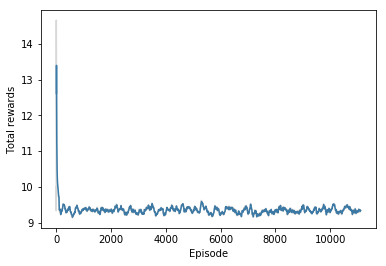

In [37]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

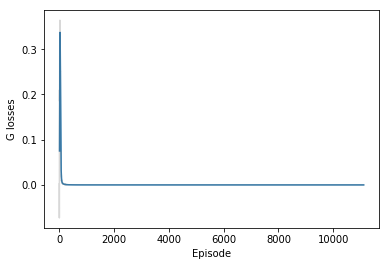

In [38]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

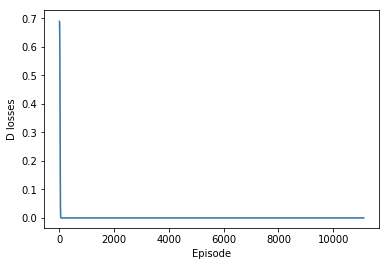

In [39]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.